<a href="https://colab.research.google.com/github/BhardwajArjit/Research-Paper-Replication/blob/main/CaaM_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook replicates the research paper titled "**Causal Attention for Unbiased Visual Recognition**" with PyTorch.

The link to the paper: https://arxiv.org/abs/2108.08782

**Causal Attention Module** (CaaM) generates data partition iteratively and self-annotates the confounders progressively to overcome the over-adjustment problem.

The ultimate goal of CaaM is to improve causal inference by adjusting for confounders more accurately.

##0. Get Setup

In [1]:
try:
  import torch
  import torchvision
  import timm
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
  print(f"timm version: {timm.__version__}")
except:
  print(f"[INFO] Couldn't find timm... installing it.")
  !pip install timm
  import timm
  print(f"timm {timm.__version__} installed successfully...")

[INFO] Couldn't find timm... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00
timm 0.9.10 installed successfully...


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  print("torchinfo installed successfully...")
  from torchinfo import summary

try:
    from pytorch_utils import download_data, set_seeds, plot_loss_curves
except ImportError:
    # If the import fails, clone the repository
    !git clone https://github.com/BhardwajArjit/Helper-Functions.git
    !mv Helper-Functions/pytorch_utils.py .
    !rm -rf Helper-Functions
    from pytorch_utils import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
torchinfo installed successfully...
Cloning into 'Helper-Functions'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 6), reused 31 (delta 5), pack-reused 0
Receiving objects: 100% (32/32), 9.60 KiB | 9.60 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# GPU provided by Google Colab
!nvidia-smi

Sat Nov  4 16:13:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##1. Get Data

In [5]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "nico_subset"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "nico_subset.zip", "wb") as f:
  request = requests.get("https://github.com/BhardwajArjit/Research-Paper-Replication/raw/main/nico_subset.zip")
  print("Downloading nico subset data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "nico_subset.zip", "r") as zip_ref:
  print(f"Uzipping nico subset data...")
  zip_ref.extractall(data_path)

data/nico_subset does not exist, creating one...
Uzipping nico subset data...


##2. Data preparation and data exploration

In [8]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/nico_subset'.
There are 3 directories and 0 images in 'data/nico_subset/train'.
There are 0 directories and 25 images in 'data/nico_subset/train/rat'.
There are 0 directories and 25 images in 'data/nico_subset/train/sheep'.
There are 0 directories and 25 images in 'data/nico_subset/train/bird'.
There are 3 directories and 0 images in 'data/nico_subset/test'.
There are 0 directories and 10 images in 'data/nico_subset/test/rat'.
There are 0 directories and 10 images in 'data/nico_subset/test/sheep'.
There are 0 directories and 10 images in 'data/nico_subset/test/bird'.


In [11]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/nico_subset/train'), PosixPath('data/nico_subset/test'))

Random image path: data/nico_subset/train/sheep/0_3_12.jpg
Image class: sheep
Image height: 678
Image width: 1200


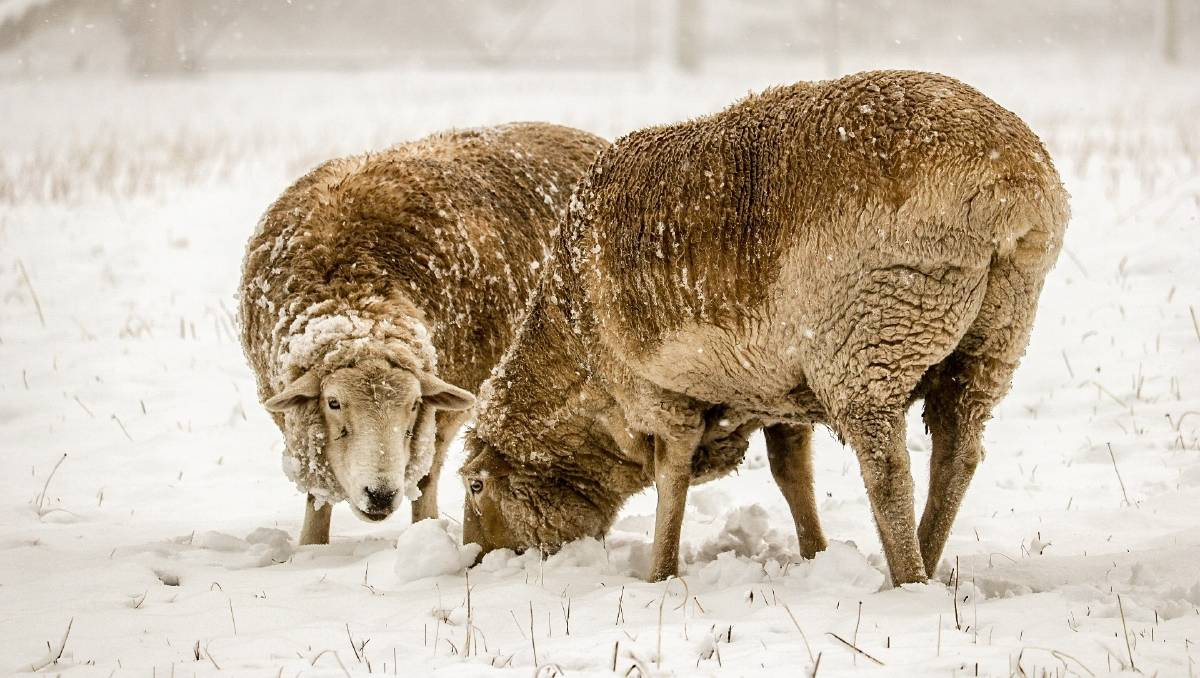

In [14]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img